<a href="https://colab.research.google.com/github/blancavazquez/CursoDatosMasivosI/blob/master/notebooks/3g_minhash_pyspark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Minhash con PySpark 
_Por Gabriel Efraín Condés Luna_

En este notebook haremos una revisión de como aplicar la técnica de *Minhash* con *PrSpark*.

Antes de pasar a los ejemplos debemos instalar nuestro entorno de desarrollo con `PySpark`

In [1]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     |████████████████████████████████| 281.4 MB 41 kB/s 
     |████████████████████████████████| 198 kB 63.9 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=7b3fb490fc2b688e473d287d99dd880dea9ad546db212972f5a9acd2b0ba51b1
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 39 not upgraded.
Need to get 36.5 MB of archives.
After this operation, 143 MB of additional disk space will be used.
Selecting previously unselected package openjdk-8-jre-headless:amd64.
(Rea

Para empezar a hacer uso de PySpark es necesario crear una `SparkSession` e importar las bibliotecas necesarias para trabajar.

In [2]:
import pyspark

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('minhash').getOrCreate()

from pyspark.ml.feature import MinHashLSH
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import CountVectorizer
from pyspark.sql.functions import col, size
import string
import nltk
nltk.download('stopwords')

import matplotlib.pyplot as plt

import seaborn as sns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Vectores dispersos

Los vectores dispersos pueden ayudarnos a representar matrices dispersas. La mayoría de los elementos de una matriz dispersa son $0$, es por esto que para ahorrar espacio es más eficiente especificar por cada renglón la lista de columnas que tienen valores distintos a cero y la lista de valores correspondientes.

Por ejemplo, un renglón de una matriz dispersa puede ser el siguiente:

$$
(1,0,0,0,0,3,0,0,2,0)
$$

Notemos que este vector se puede definir especificando lo siguiente:

1.   El tamaño del vector: $10$
2.   Las entradas del vector que son distintas de cero: $[0,5,8]$ (índices desde cero)
3.   Los valores correspondientes a dichas entradas: $[1,3,2]$

Nosotros podemos definir vectores dispersos en *PySpark* usando estos parámetros de la siguiente manera:

In [3]:
vector = Vectors.sparse(10, [0, 5, 8], [1, 3, 2])
vector.toArray()

array([1., 0., 0., 0., 0., 3., 0., 0., 2., 0.])

Podemos crear un DataFrame con vectores dispersos de la siguiente manera:

In [4]:
matriz_dispersa = [(Vectors.sparse(6, [0, 1, 2], [1.0, 1.0, 1.0]),),
                   (Vectors.sparse(6, [2, 3, 4], [1.0, 1.0, 1.0]),),
                   (Vectors.sparse(6, [0, 2, 4], [1.0, 1.0, 1.0]),)]

matriz_dispersa = spark.createDataFrame(matriz_dispersa)

matriz_dispersa.show()

+--------------------+
|                  _1|
+--------------------+
|(6,[0,1,2],[1.0,1...|
|(6,[2,3,4],[1.0,1...|
|(6,[0,2,4],[1.0,1...|
+--------------------+



*CountVectorizer* es una clase que nos ayuda a extraer el vocabulario de un conjunto de documentos, así como a generar representaciones dispersas de los documentos.

Por ejemplo, si tenemos los siguientes documentos:

$$
\begin{split}
doc_0 & = abbc \\
doc_1 & = bcd \\
doc_2 & = ac 
\end{split}
$$

Su matriz de representación sería:

| Elemento del vocabulario | $doc_0$ | $doc_1$ |$doc_2$ |
| --- | --- | --- | --- | 
| a | 1 | 0 | 1 | 
| b | 2 | 1 | 0 | 
| c | 1 | 1 | 0 | 
| d | 0 | 1 | 1 |

La clase *CountVectorizer* nos ayuda a encontrar la matriz de representación convertida en vectores dispersos dados los documentos.


In [5]:
documentos = spark.createDataFrame([(0, 'a,b,b,c'.split(',')),
                                    (1, 'b,c,d'.split(',')),
                                    (2, 'a,c'.split(','))],
                                   ['id', 'palabras'])

documentos.show()

+---+------------+
| id|    palabras|
+---+------------+
|  0|[a, b, b, c]|
|  1|   [b, c, d]|
|  2|      [a, c]|
+---+------------+



In [6]:
cv = CountVectorizer(inputCol  = 'palabras', 
                     outputCol = 'features', 
                     vocabSize = 6, 
                     minDF     = 1)

modelo = cv.fit(documentos)
mat_rep = modelo.transform(documentos)

mat_rep.show(truncate = False)

+---+------------+-------------------------+
|id |palabras    |features                 |
+---+------------+-------------------------+
|0  |[a, b, b, c]|(4,[0,1,2],[2.0,1.0,1.0])|
|1  |[b, c, d]   |(4,[0,1,3],[1.0,1.0,1.0])|
|2  |[a, c]      |(4,[1,2],[1.0,1.0])      |
+---+------------+-------------------------+



## Conjunto de datos
Los datos que usaremos son de la serie Rick y Morty. Corresponden a transcripciones de los diálogos de los personajes. La base de datos cuenta con los siguientes campos:

*   Indice (Identificador único del renglón en el conjunto de datos)
*   Temporada
*   Número de episodio
*   Nombre del episodio
*   Línea de diálogo





Descargamos el archivo `RickAndMortyScripts.csv` de [https://www.kaggle.com/datasets/andradaolteanu/rickmorty-scripts](https://www.kaggle.com/datasets/andradaolteanu/rickmorty-scripts) y los cargamos:

In [7]:
from google.colab import files
uploaded = files.upload()

Saving RickAndMortyScripts.csv to RickAndMortyScripts.csv


Cargamos los datos en un DataFrame de *PySpark*.

In [8]:
df_rym = spark.read.csv('/content/RickAndMortyScripts.csv', header = True, inferSchema = True)

Verificamos que los datos se cargaron correctamente.




In [9]:
df_rym.printSchema()

root
 |-- index: integer (nullable = true)
 |-- season no.: integer (nullable = true)
 |-- episode no.: integer (nullable = true)
 |-- episode name: string (nullable = true)
 |-- name: string (nullable = true)
 |-- line: string (nullable = true)



Imprimos una muestra de los datos

In [10]:
df_rym.show(5)

+-----+----------+-----------+------------+-----+--------------------+
|index|season no.|episode no.|episode name| name|                line|
+-----+----------+-----------+------------+-----+--------------------+
|    0|         1|          1|       Pilot| Rick|Morty! You gotta ...|
|    1|         1|          1|       Pilot|Morty|What, Rick? What’...|
|    2|         1|          1|       Pilot| Rick|I got a surprise ...|
|    3|         1|          1|       Pilot|Morty|It's the middle o...|
|    4|         1|          1|       Pilot| Rick|Come on, I got a ...|
+-----+----------+-----------+------------+-----+--------------------+
only showing top 5 rows



In [11]:
df_rym.printSchema()

root
 |-- index: integer (nullable = true)
 |-- season no.: integer (nullable = true)
 |-- episode no.: integer (nullable = true)
 |-- episode name: string (nullable = true)
 |-- name: string (nullable = true)
 |-- line: string (nullable = true)



Para fines del análisis que llevaremos a cabo, solo consideraremos las columnas de nombre y dialogo del personaje.

In [12]:
df_rym = df_rym.select('index', 'name', 'line')
df_rym.show(5)

+-----+-----+--------------------+
|index| name|                line|
+-----+-----+--------------------+
|    0| Rick|Morty! You gotta ...|
|    1|Morty|What, Rick? What’...|
|    2| Rick|I got a surprise ...|
|    3|Morty|It's the middle o...|
|    4| Rick|Come on, I got a ...|
+-----+-----+--------------------+
only showing top 5 rows



Para hacer más simple el analisis solo consideraremos los dialogos de los personajes principales.

In [13]:
personajes_principales = ['Rick', 'Morty', 'Beth', 'Jerry', 'Summer']
df_rym = df_rym.where(df_rym.name.isin(personajes_principales))

Revisemos la distribución de diálogos de los personajes que tienen más diálogos.

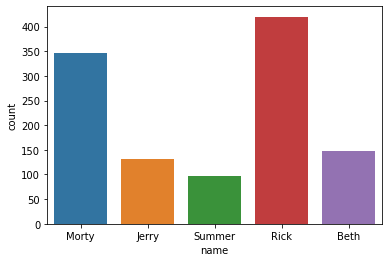

In [14]:
df_dist_dialog = df_rym.groupBy('name') \
                       .count() \
                       .toPandas()

sns.barplot( x    = 'name', 
             y    = 'count', 
             data = df_dist_dialog)
plt.show()

Preprocesamos los documentos del conjunto.

In [15]:
df_rym.limit(3) \
      .toPandas() \
      .loc[0:3, 'line']

0    Morty! You gotta come on. Jus'... you gotta co...
1                         What, Rick? What’s going on?
2                     I got a surprise for you, Morty.
Name: line, dtype: object

Convertimos a minúsculas.



In [16]:
df_rym = df_rym.rdd \
               .map(lambda x: (x[0], x[1], x[2].lower())) \
               .toDF(['id', 'nombre', 'dialog']) 

df_rym.limit(3) \
      .toPandas() \
      .loc[0:3,'dialog']

0    morty! you gotta come on. jus'... you gotta co...
1                         what, rick? what’s going on?
2                     i got a surprise for you, morty.
Name: dialog, dtype: object

Eliminamos signos de puntuación.

In [17]:
df_rym = df_rym.rdd \
           .map(lambda x: (x[0], x[1], x[2].translate(str.maketrans('', '', string.punctuation)))) \
           .toDF(['id', 'nombre', 'dialog']) 

df_rym.limit(3) \
      .toPandas() \
      .loc[0:3,'dialog']

0    morty you gotta come on jus you gotta come wit...
1                            what rick what’s going on
2                       i got a surprise for you morty
Name: dialog, dtype: object

Quitamos _stopwords_

In [18]:
palabras_vacias = nltk.corpus.stopwords.words('english')

def quita_palabras_vacias(texto):
  texto_limpio = [ palabra for palabra in texto if palabra not in palabras_vacias ]
  return texto_limpio

df_rym = df_rym.rdd \
           .map(lambda x: (x[0], x[1], x[2].split(' '))) \
           .map(lambda x: (x[0], x[1], quita_palabras_vacias(x[2]))) \
           .toDF(['id', 'nombre', 'dialog']) \
           .filter(size('dialog') > 0) # Elimina texto vacio

df_rym.limit(7) \
      .toPandas() \
      .loc[0:7,'dialog']

0               [morty, gotta, come, jus, gotta, come]
1                                [rick, what’s, going]
2                               [got, surprise, morty]
3                             [middle, night, talking]
4                 [come, got, surprise, , come, hurry]
5                       [ow, ow, youre, tugging, hard]
6    [gotta, go, gotta, get, outta, come, got, surp...
Name: dialog, dtype: object

Ahora necesitamos representar los datos como una matriz de representación, la cual nos dice qué elementos del vocabulario aparecen en cada elemento del conjunto de datos.

| Elemento del vocabulario | $S_1$ | $S_2$ |$S_3$ | $S_4$ |
| --- | --- | --- | --- | --- |
| palabra 1 | 1 | 1 | 1 | 0 |
| palabra 2 | 0 | 1 | 1 | 0 |
| palabra 3 | 0 | 1 | 0 | 1 |
| palabra 4 | 1 | 1 | 0 | 0 |
| palabra 5 | 1 | 1 | 0 | 0 |
| palabra 6 | 0 | 0 | 1 | 1 |

Esto lo logramos usando la clase `CountVectorizerModel`



In [19]:
cv = CountVectorizer(inputCol  = 'dialog', 
                     outputCol = 'features',
                     binary    = True, 
                     vocabSize = 3000, 
                     minDF     = 1)    

La forma de calcular la matriz de representacion es la siguiente:

In [20]:
matriz_representacion = cv.fit(df_rym)
df_rym_mr = matriz_representacion.transform(df_rym)
df_rym_mr.show(10)

+---+------+--------------------+--------------------+
| id|nombre|              dialog|            features|
+---+------+--------------------+--------------------+
|  0|  Rick|[morty, gotta, co...|(2442,[0,24,101,1...|
|  1| Morty|[rick, what’s, go...|(2442,[3,40,353],...|
|  2|  Rick|[got, surprise, m...|(2442,[0,17,325],...|
|  3| Morty|[middle, night, t...|(2442,[65,113,116...|
|  4|  Rick|[come, got, surpr...|(2442,[1,17,24,32...|
|  5| Morty|[ow, ow, youre, t...|(2442,[7,171,570,...|
|  6|  Rick|[gotta, go, gotta...|(2442,[0,5,12,17,...|
|  7|  Rick|[think, flying, v...|(2442,[0,20,110,3...|
|  8| Morty|[yeah, rick, iits...|(2442,[3,14,129,3...|
|  9|  Rick|[morty, had—, to—...|(2442,[0,44,198,6...|
+---+------+--------------------+--------------------+
only showing top 10 rows



## Minhash y distancia de Jaccard

Para crear un modelo basado en Minhashing hacemos lo siguiente:


In [21]:
minhash = MinHashLSH(inputCol      = 'features', 
                     outputCol     = 'hashes', 
                     numHashTables = 100)

modelo_mh = minhash.fit(df_rym_mr)

Podemos mostrar cómo se ve la *signature matrix* creada a partir de la matriz de representación.

In [22]:
df_rym_mh = modelo_mh.transform(df_rym_mr) 


df_rym_mh.limit(10) \
         .show()

+---+------+--------------------+--------------------+--------------------+
| id|nombre|              dialog|            features|              hashes|
+---+------+--------------------+--------------------+--------------------+
|  0|  Rick|[morty, gotta, co...|(2442,[0,24,101,1...|[[2.2358881E7], [...|
|  1| Morty|[rick, what’s, go...|(2442,[3,40,353],...|[[4.9935533E7], [...|
|  2|  Rick|[got, surprise, m...|(2442,[0,17,325],...|[[8.02311407E8], ...|
|  3| Morty|[middle, night, t...|(2442,[65,113,116...|[[9.72454295E8], ...|
|  4|  Rick|[come, got, surpr...|(2442,[1,17,24,32...|[[2.2358881E7], [...|
|  5| Morty|[ow, ow, youre, t...|(2442,[7,171,570,...|[[1.69608093E8], ...|
|  6|  Rick|[gotta, go, gotta...|(2442,[0,5,12,17,...|[[2.2358881E7], [...|
|  7|  Rick|[think, flying, v...|(2442,[0,20,110,3...|[[1.76892504E8], ...|
|  8| Morty|[yeah, rick, iits...|(2442,[3,14,129,3...|[[3.24141716E8], ...|
|  9|  Rick|[morty, had—, to—...|(2442,[0,44,198,6...|[[4.33407881E8], ...|
+---+------+

Podemos calcular las distancias entre los elementos de dos _dataframes_.

In [23]:
similaridad_entre_lineas = modelo_mh.approxSimilarityJoin(datasetA  = df_rym_mh,  
                                                      datasetB  = df_rym_mh, 
                                                      threshold = 0.5, 
                                                      distCol   = 'dist_jaccard') \
                                    .select(col('datasetA.nombre').alias('nombre_1'), 
                                        col('datasetB.nombre').alias('nombre_2'), 
                                        col('dist_jaccard')) \
                                    .where(col('dist_jaccard') > 0) # Quitamos las que son iguales

similaridad_entre_lineas.show(4)      

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


+--------+--------+-------------------+
|nombre_1|nombre_2|       dist_jaccard|
+--------+--------+-------------------+
|   Morty|   Morty|0.33333333333333337|
|   Morty|   Morty|0.33333333333333337|
|  Summer|   Morty|0.33333333333333337|
|   Jerry|   Morty|0.33333333333333337|
+--------+--------+-------------------+
only showing top 4 rows



Veamos en cuántas pudimos identificar los diálogos por personaje

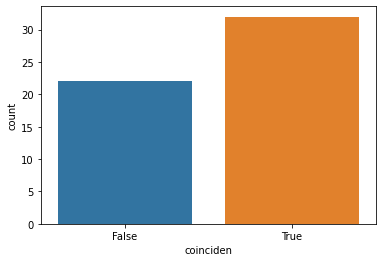

In [24]:
coincidencias = similaridad_entre_lineas.withColumn('coinciden', 
                                                    col('nombre_1') == col('nombre_2')) \
                                        .groupBy('coinciden') \
                                        .count() \
                                        .toPandas()

sns.barplot( x    = 'coinciden', 
             y    = 'count', 
             data = coincidencias)
plt.show()

Calculamos los elementos más cercanos a un elemento dado y extraemos una línea correspondinete a Morty.

In [25]:
[renglon] = df_rym_mr.where(df_rym_mr.id == 170).collect()
print(renglon)
linea = renglon[3]
print(linea)

Row(id=170, nombre='Morty', dialog=['oh', 'geez', 'rick', 'really', 'dont', 'want'], features=SparseVector(2442, {2: 1.0, 3: 1.0, 9: 1.0, 18: 1.0, 33: 1.0, 64: 1.0}))
(2442,[2,3,9,18,33,64],[1.0,1.0,1.0,1.0,1.0,1.0])


Buscamos los $k$ elementos más cercanos

In [26]:
vecinos_cercanos = modelo_mh.approxNearestNeighbors(dataset             = df_rym_mh, 
                                                    key                 = linea, 
                                                    numNearestNeighbors = 50, 
                                                    distCol             = 'dist_jaccard') \
                            .where(col('dist_jaccard') > 0) # Quitamos la línea repetida

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


Veamos cuántas líneas corresponden a cada personaje

In [27]:
vecinos_cercanos_hist = vecinos_cercanos.groupby('nombre') \
                                        .count() \
                                        .toPandas()

Visualicemos los resultados

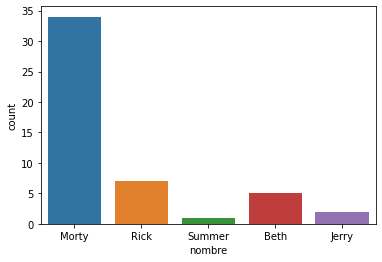

In [28]:
sns.barplot( x    = 'nombre', 
             y    = 'count', 
             data = vecinos_cercanos_hist)
plt.show()